## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

## Helper functions

In [21]:
# Color and gradient thresholding
def threshold(img, s_thresh=(170, 255), sx_thresh=(10, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

# Perspective transform
def warp_plus(img):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
#     print(src)
#     print(dst)

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) # use undistorted image here
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # image plus lines
    img_p = np.copy(img)
    src_p = np.int32(src)
    src_p = src_p.reshape((-1,1,2))
    img_p = cv2.polylines(img_p, [src_p], True, (255,0,0), 2)

    # warped image plus lines
    warped_p = np.copy(warped)
    dst_p = np.int32(dst)
    dst_p = dst_p.reshape((-1,1,2))
    warped_p = cv2.polylines(warped_p, [dst_p], True, (255,0,0), 2)

    return warped, img_p, warped_p, M, Minv

# Finding the lines with sliding window
def find_lane_pixels(binary_warped):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Set the start point of left line and right line at 320 and 960 respectively
    leftx_base = np.array(320)
    rightx_base = leftx_base + 640 #np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 8
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Store centers of the windows
    win_center_leftx = []
    win_center_rightx = []
    win_center_y = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Track centers of the windows
        win_center_y.append(np.mean((win_y_low, win_y_high)).astype(int))
        win_center_leftx.append(leftx_current.astype(int))
        win_center_rightx.append(rightx_current.astype(int))
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = [i for i, e in enumerate(nonzerox) if (win_y_low <= nonzeroy[i] <= win_y_high) and (win_xleft_low <= e <= win_xleft_high)]
        good_right_inds = [i for i, e in enumerate(nonzerox) if (win_y_low <= nonzeroy[i] <= win_y_high) and (win_xright_low <= e <= win_xright_high)]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        leftx_current_temp = leftx_current
        rightx_current_temp = rightx_current
        # If found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds]).astype(int)
            rightx_current_temp = leftx_current + 640
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds]).astype(int)
            leftx_current_temp = rightx_current - 640
            
        rightx_current = np.mean((rightx_current, rightx_current_temp)).astype(int)
        leftx_current = np.mean((leftx_current, leftx_current_temp)).astype(int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    left_lane_inds = left_lane_inds.astype(int)
    right_lane_inds = right_lane_inds.astype(int)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    leftx = np.concatenate((leftx, win_center_leftx))
    lefty = np.concatenate((lefty, win_center_y))
    rightx = np.concatenate((rightx, win_center_rightx))
    righty = np.concatenate((righty, win_center_y))
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    # Draw the fitted poly lanes onto the image
    out_img = cv2.polylines(out_img, np.int_([pts_left]), isClosed=False, color=(255, 255, 0), thickness=6)
    out_img = cv2.polylines(out_img, np.int_([pts_right]), isClosed=False, color=(255, 255, 0), thickness=6)
    
    return out_img, left_fit, right_fit, ploty

# Measure curvature and offset from the center
def measure_curvature_real(img, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 720
    
    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = (1 + (2 * left_fit[0] * y_eval * ym_per_pix + left_fit[1]) ** 2) ** 1.5 / abs(2 * left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1 + (2 * right_fit[0] * y_eval * ym_per_pix + right_fit[1]) ** 2) ** 1.5 / abs(2 * right_fit[0]) ## Implement the calculation of the right line here

    # Implement the calculation of center offset
    left_fit_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fit_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    offset = (left_fit_eval + right_fit_eval) / 2 * xm_per_pix - img.shape[1] / 2 * xm_per_pix # 3.7 meters in total in x dimension

    return left_curverad, right_curverad, offset

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask

## Camera calibration

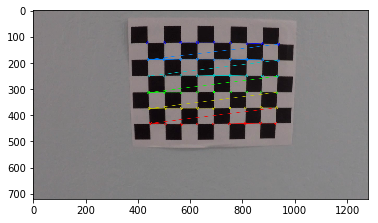

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:  
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        

In [4]:
# Perform camera calibration
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

True

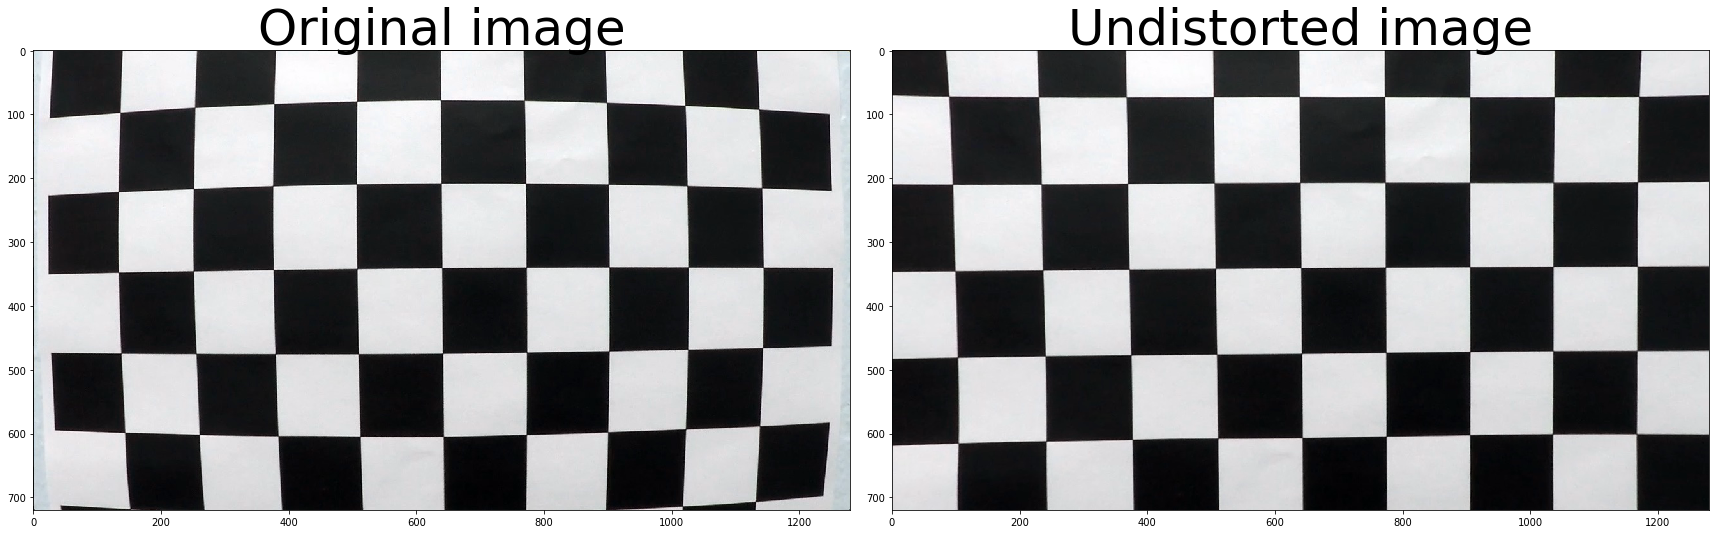

In [5]:
# Test camera calibration using calibration1.jpg
img = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=50)

cv2.imwrite("output_images/original_img_chessboard.jpg", img)
cv2.imwrite("output_images/undist_img_chessboard.jpg", undist)

## Apply a distortion correction to raw images

(720, 1280, 3)


True

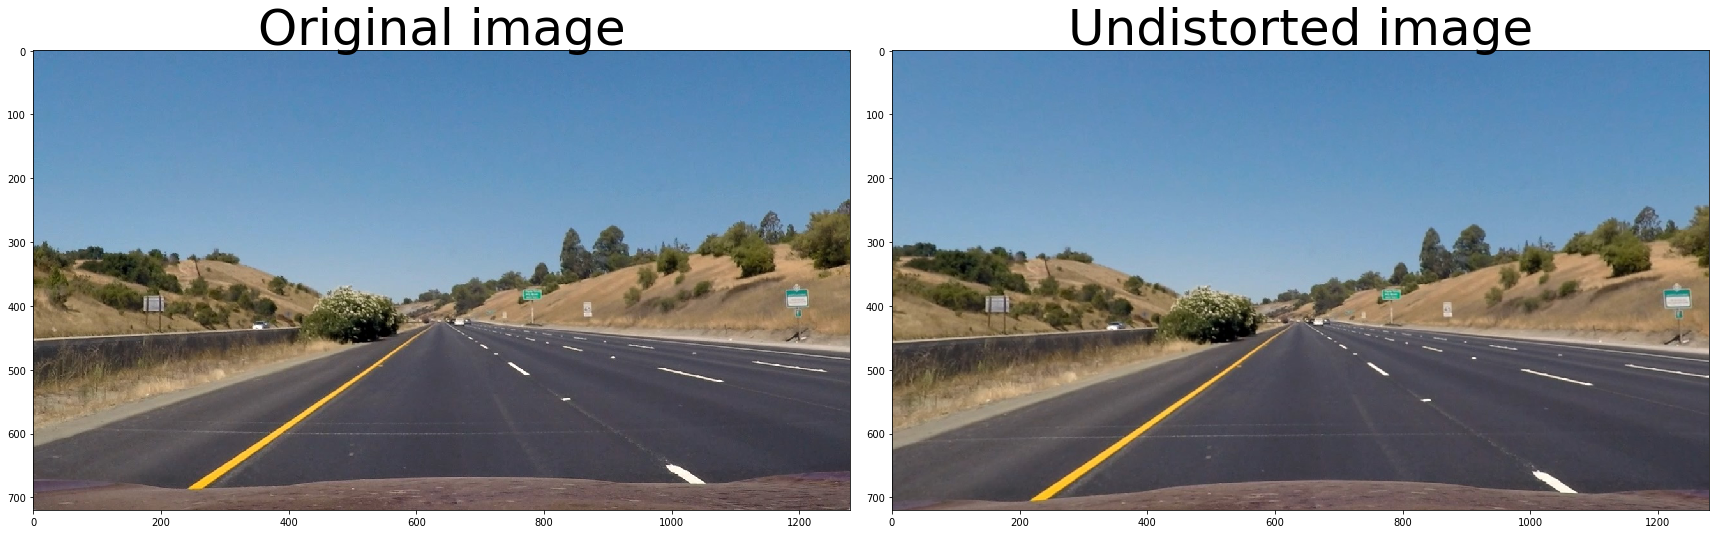

In [6]:
img = cv2.imread('test_images/straight_lines1.jpg')
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=50)

cv2.imwrite("output_images/original_img_road.jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2.imwrite("output_images/undist_img_road.jpg", cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))

## Color and gradient thresholding

True

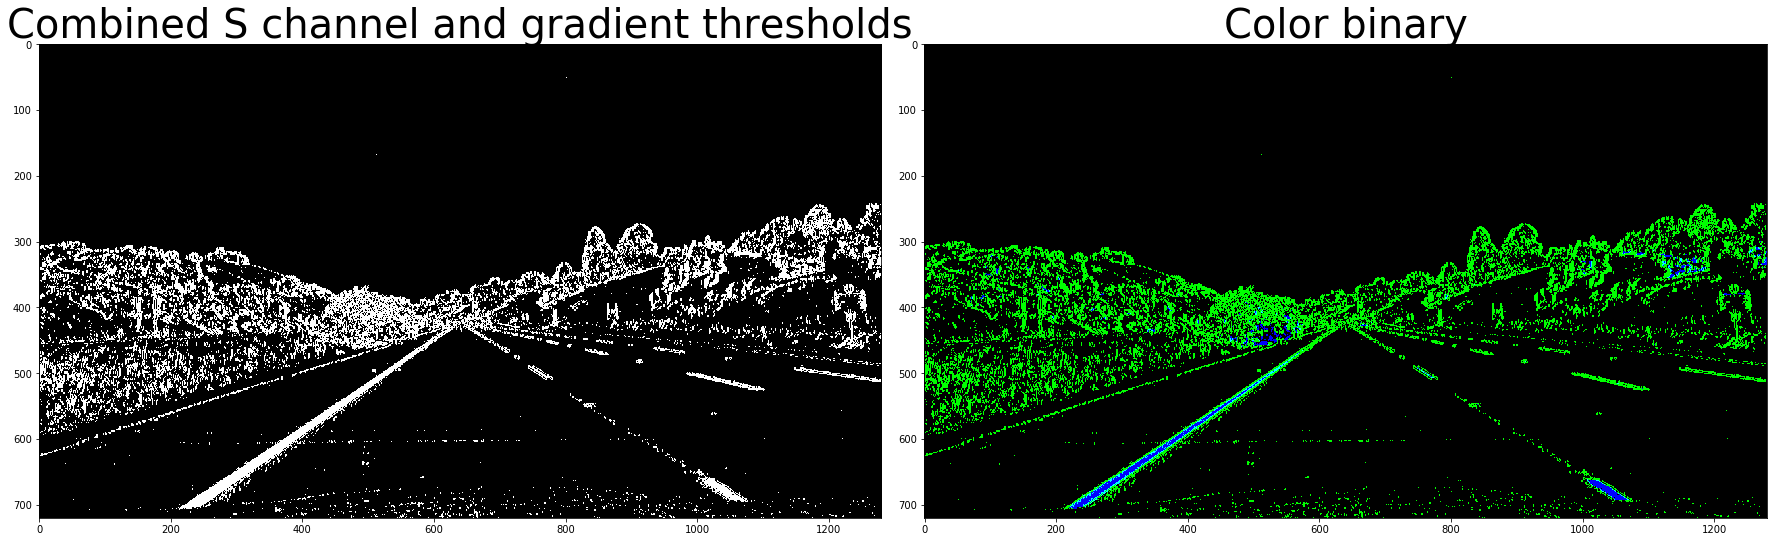

In [7]:
color_binary, combined_binary = threshold(undist) # Use undistorted image here
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.set_title('Combined S channel and gradient thresholds', fontsize=40)
ax1.imshow(combined_binary, cmap='gray')

ax2.imshow(color_binary)
ax2.set_title('Color binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/threshold_binary.jpg", combined_binary * 255)
cv2.imwrite("output_images/threshold_color.jpg", cv2.cvtColor(color_binary, cv2.COLOR_RGB2BGR))

## Perspective transform

[[  580.           460.        ]
 [  193.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  705.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


True

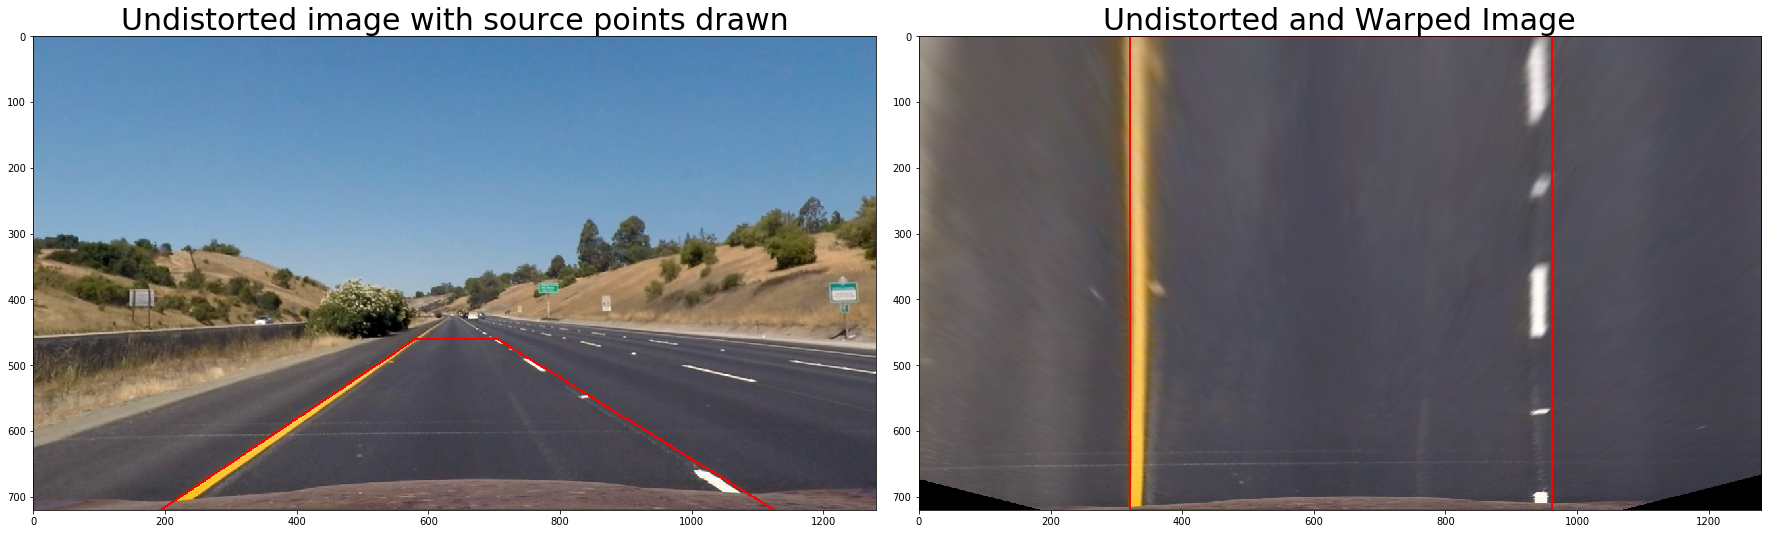

In [8]:
warped, img_p, warped_p, M, Minv = warp_plus(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_p)
ax1.set_title('Undistorted image with source points drawn', fontsize=30)

ax2.imshow(warped_p)
ax2.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/road_pre_perspective_trans.jpg", cv2.cvtColor(img_p, cv2.COLOR_RGB2BGR))
cv2.imwrite("output_images/road_post_perspective_trans.jpg", cv2.cvtColor(warped_p, cv2.COLOR_RGB2BGR))

[[  580.           460.        ]
 [  193.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  705.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


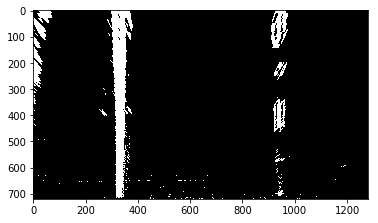

In [9]:
# warp the image after thresholding
binary_warped, combined_binary_p, binary_warped_p, M, Minv = warp_plus(combined_binary)
plt.imshow(binary_warped, cmap='gray')

## Finding the lines -- Sliding windows

True

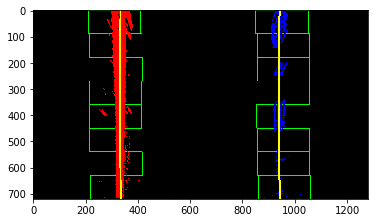

In [10]:
# Apply a mask
vertices = np.array([[(200, img_size[0]),(1200, img_size[0]),(1200, 0),(200, 0)]], dtype=np.int32)
binary_warped, mask = region_of_interest(binary_warped, vertices)

out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped)
plt.imshow(out_img)

cv2.imwrite("output_images/sliding_window.jpg", cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))

## Measure curvature

In [11]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offset = measure_curvature_real(img, left_fit, right_fit)
curvature = np.mean([left_curverad,right_curverad])

print(left_curverad, 'm', right_curverad, 'm', offset, 'm')

13859.5935071 m 15857.5493166 m 0.00154088689517 m


# Plot back

In [12]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
result = cv2.putText(result, 'Radius of Curvature is %1.3f m'% curvature, 
                     (30,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
result = cv2.putText(result, 'Vehicle is %1.3f m off the center'% offset, 
                     (30,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)

cv2.imwrite("output_images/plot_back_result.jpg", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

True

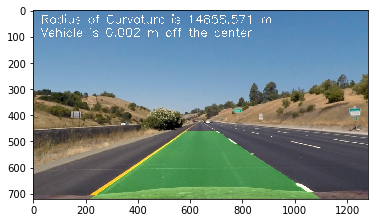

In [13]:
plt.imshow(result)

## Pipeline for lane finding in video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
COUNT = 0
N = 4

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        global N
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.zeros((N,3)) 
        #polynomial coefficients for last n
        self.lastn_fit = np.zeros((N,3))  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')  

In [17]:
left_line = Line()
right_line = Line()

def process_image(img):
    global COUNT, N
    img_size = (img.shape[1], img.shape[0])
    
    # Undistortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Color and gradient thresholding
    color_binary, combined_binary = threshold(undist) # Use undistorted image here
    
    # Perspective transform
    warped, img_p, warped_p, M, Minv = warp_plus(img)
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Add a mask
    vertices = np.array([[(200, img_size[0]),(1200, img_size[0]),(1200, 0),(200, 0)]], dtype=np.int32)
    binary_warped, mask = region_of_interest(binary_warped, vertices)
    
    out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped)
    
    # Use the line class
    ind = COUNT % N # index of current line
    left_line.lastn_fit[ind] = np.copy(left_fit)
    right_line.lastn_fit[ind] = np.copy(right_fit)
    
    if COUNT < N:
        left_line.best_fit[ind] = np.sum(left_line.lastn_fit, axis=0)/(COUNT+1) #np.copy(left_fit) #
        right_line.best_fit[ind] = np.sum(right_line.lastn_fit, axis=0)/(COUNT+1) #np.copy(right_fit) #
    else:
        left_line.best_fit[ind] = np.copy(left_fit)
        left_line.best_fit[ind] = np.mean(left_line.best_fit, axis=0)
        right_line.best_fit[ind] = np.copy(right_fit)
        right_line.best_fit[ind] = np.mean(right_line.best_fit, axis=0)
        
        last_ind = (COUNT % N + N - 1) % N # index of last line
        right_line.diffs = np.sum(abs(right_line.best_fit[ind] - right_line.best_fit[last_ind]))
        if right_line.diffs > 10:
            right_line.best_fit[ind] = np.copy(right_line.best_fit[last_ind])
        
    left_fit_best = np.copy(left_line.best_fit[ind])
    right_fit_best = np.copy(right_line.best_fit[ind])
    
    # Measure curvature
    left_curverad, right_curverad, offset = measure_curvature_real(img, left_fit_best, right_fit_best)
    curvature = np.mean([left_curverad,right_curverad])
    
    # Plot back
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fitx = left_fit_best[0]*ploty**2 + left_fit_best[1]*ploty + left_fit_best[2]
    right_fitx = right_fit_best[0]*ploty**2 + right_fit_best[1]*ploty + right_fit_best[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    result = cv2.putText(result, 'Radius of Curvature is %1.3f m'% curvature, 
                         (30,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
    result = cv2.putText(result, 'Vehicle is %1.3f m off the center'% offset, 
                         (30,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
    COUNT += 1
    return result

In [22]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



 24%|██▍       | 303/1261 [02:23<07:24,  2.16it/s]


 48%|████▊     | 605/1261 [04:49<04:31,  2.41it/s]


 72%|███████▏  | 907/1261 [07:15<02:56,  2.00it/s]


 96%|█████████▌| 1205/1261 [09:47<00:26,  2.12it/s]


100%|█████████▉| 1260/1261 [10:13<00:00,  1.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 7min 57s, sys: 12.8 s, total: 8min 10s
Wall time: 10min 16s


In [19]:
## Get video frames
# vidcap = cv2.VideoCapture('project_video.mp4')
# vidcap.set(cv2.CAP_PROP_POS_MSEC,29000)      # just cue to 20 sec. position
# success,image = vidcap.read()
# count = 0
# while success:
#   cv2.imwrite("test_images/frame%d.jpg" % count, image)     # save frame as JPEG file      
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   count += 1